In [3]:
import matplotlib.pyplot as plt
import sympy
import numpy as np
import itertools
from tqdm import tqdm

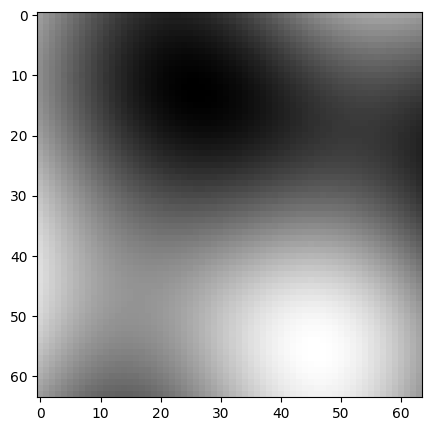

In [4]:
def noise2d(
  min_x: float,
  max_x: float,
  min_y: float,
  max_y: float,
  seed: int,
  x: float,
  y: float,
) -> float:
  np.random.seed(seed)
  min_x = int(min_x)
  max_x = int(np.ceil(max_x))
  min_y = int(min_y)
  max_y = int(np.ceil(max_y))
  thetas = np.random.uniform(0, 2*np.pi, size=(max_y-min_y+1, max_x-min_x+1))
  gradient_x = np.cos(thetas)
  gradient_y = np.sin(thetas)
  
  x0y0_grad_x_conditions = []
  x0y0_grad_y_conditions = []
  x0y1_grad_x_conditions = []
  x0y1_grad_y_conditions = []
  x1y0_grad_x_conditions = []
  x1y0_grad_y_conditions = []
  x1y1_grad_x_conditions = []
  x1y1_grad_y_conditions = []

  x0_conditions = []
  y0_conditions = []
  for y_ in range(min_y, max_y):
    for x_ in range(min_x, max_x):
      condition = (x <= x_+1) & (y <= y_+1)
      x0y0_grad_x_conditions.append((gradient_x[y_  , x_  ], condition))
      x0y0_grad_y_conditions.append((gradient_y[y_  , x_  ], condition))
      x0y1_grad_x_conditions.append((gradient_x[y_+1, x_  ], condition))
      x0y1_grad_y_conditions.append((gradient_y[y_+1, x_  ], condition))
      x1y0_grad_x_conditions.append((gradient_x[y_  , x_+1], condition))
      x1y0_grad_y_conditions.append((gradient_y[y_  , x_+1], condition))
      x1y1_grad_x_conditions.append((gradient_x[y_+1, x_+1], condition))
      x1y1_grad_y_conditions.append((gradient_y[y_+1, x_+1], condition))

      x0_conditions.append((x_, condition))
      y0_conditions.append((y_, condition))
  
  x0y0_grad_x = sympy.Piecewise(*x0y0_grad_x_conditions)
  x0y0_grad_y = sympy.Piecewise(*x0y0_grad_y_conditions)
  x0y1_grad_x = sympy.Piecewise(*x0y1_grad_x_conditions)
  x0y1_grad_y = sympy.Piecewise(*x0y1_grad_y_conditions)
  x1y0_grad_x = sympy.Piecewise(*x1y0_grad_x_conditions)
  x1y0_grad_y = sympy.Piecewise(*x1y0_grad_y_conditions)
  x1y1_grad_x = sympy.Piecewise(*x1y1_grad_x_conditions)
  x1y1_grad_y = sympy.Piecewise(*x1y1_grad_y_conditions)

  x0 = sympy.Piecewise(*x0_conditions)
  y0 = sympy.Piecewise(*y0_conditions)
  x1 = x0 + 1
  y1 = y0 + 1

  def dot_grid_gradient(ix, iy, x, y, grad_x, grad_y):
    dx = x - ix
    dy = y - iy
    return dx*grad_x + dy*grad_y


  def interpolate(a0: float, a1: float, t: float) -> float:
    # return (a1 - a0) * t + a0
    # return (a1 - a0) * (3 - 2*t) * t * t + a0
    return (a1 - a0) * ((t * (t * 6.0 - 15.0) + 10.0) * t * t * t) + a0

  n0 = dot_grid_gradient(x0, y0, x, y, x0y0_grad_x, x0y0_grad_y)
  n1 = dot_grid_gradient(x1, y0, x, y, x1y0_grad_x, x1y0_grad_y)
  ix0 = interpolate(n0, n1, x-x0)

  n0 = dot_grid_gradient(x0, y1, x, y, x0y1_grad_x, x0y1_grad_y)
  n1 = dot_grid_gradient(x1, y1, x, y, x1y1_grad_x, x1y1_grad_y)
  ix1 = interpolate(n0, n1, x-x0)

  interpolated = interpolate(ix0, ix1, y-y0)

  return interpolated * .5 + .5


if __name__ == "__main__":
  min_x = 0
  max_x=1
  min_y = 0
  max_y=1
  seed=0

  width=64
  height=64
  x, y = sympy.symbols("x y")
  noise = noise2d(min_x, max_x, min_y, max_y, seed, x, y)
  field = np.empty((width, height))
  for v, u in tqdm(itertools.product(range(height), range(width)), leave=False, total=width*height):
    field[v,u] = noise\
      .subs(x, u/(width-1) * (max_x-min_x) + min_x)\
      .subs(y, v/(height-1) * (max_y-min_y) + min_y)
    
  fig, ax = plt.subplots(figsize=(5, 5))

  ax.imshow(field, cmap="gray")
